# Multi-Task Regularized Logistic Regression

**References:** 
1. J. Chen, J. Zhou, and J. Ye. [*Integrating Low-Rank and Group-Sparse Structures for Robust Multi-Task Learning*](https://dl.acm.org/doi/abs/10.1145/2020408.2020423) in Proceedings of the 17th ACM SIGKDD International Conference on Knowledge Discovery and Data Mining, pp. 42-50, August 2011.
2. J. Friedman, T. Hastie, and R. Tibshirani. [*A Note on the Group Lasso and a Sparse Group Lasso*](https://arxiv.org/abs/1001.0736), arXiv preprint arXiv:1001.0736, 2010.

## Introduction

In many applications, we are assigned multiple regression tasks that are correlated via a certain structure. Multi-task regression aims to exploit this structure by fitting the regression models simultaneously, so knowledge from one task can be transferred to the other tasks. We consider the multi-task regularized regression problem with $L$ tasks

$$\text{minimize}~ \phi(W\theta, Y) + r(\theta),$$

where $\theta = [\theta_1~\ldots~\theta_L] \in \mathbf{R}^{s \times L}$ is the variable, $W \in \mathbf{R}^{p \times s}$ is the feature matrix shared across tasks, and $Y = [y_1~\ldots~y_L] \in \mathbf{R}^{p \times L}$ contains the $p$ class labels for each task $l = 1,\ldots,L$. Here $\phi:\mathbf{R}^{p \times L} \times \mathbf{R}^{p \times L} \rightarrow \mathbf{R}$ is the loss function and $r:\mathbf{R}^{s \times L} \rightarrow \mathbf{R}$ is the regularizer.

We focus on the binary classification problem (all entries $Y_{il} \in \{-1,1\}$) and take our loss function to be the logistic loss summed over samples and tasks:

$$\phi(Z,Y)= \sum_{l=1}^L\sum_{i=1}^p\log\left(1+\exp(-Y_{il}Z_{il})\right).$$

The task variables are coupled by a low-rank, column-sparse structure, which we capture using the regularizer

$$r(\theta) = \alpha\|\theta\|_{2,1} + \beta\|\theta\|_*,$$

where $\|\theta\|_{2,1}=\sum_{l=1}^L\|\theta_l\|_2$ is the group lasso penalty, $\|\theta\|_*$ is the nuclear norm, and $\alpha>0$ and $\beta>0$ are parameters.

## Reformulate and Solve Problem

This problem can be converted to standard form by letting

$$f_1(Z) = \phi(Z,Y), \quad f_2(\theta) = \alpha\|\theta\|_{2,1}, 
\quad f_3(\tilde \theta) = \beta\|\tilde \theta\|_*,$$

$$A = \left[\begin{array}{cccc}
I & -W & 0 \\
0 & I & -I
\end{array}\right],
\quad x = \left[\begin{array}{c} Z \\ \theta \\ \tilde\theta 
\end{array}\right],
\quad b = 0.$$

We solve an instance with $p = 100, s = 80, L = 6$, and $\alpha = \beta = 0.1$. The entries of $W$ are drawn IID from $\mathcal{N}(0,1)$. To construct $Y$, we generate $\theta^{\text{true}} \in \mathbf{R}^{s\times L}$ by drawing its entries IID from $N(0,1)$, then set $Y = \textbf{sign}(W\theta^{\text{true}})$, where the signum function is applied elementwise with the convention $\textbf{sign}(0)=-1$.

In [1]:
import numpy as np
from scipy import sparse
from scipy.special import expit
from a2dr import a2dr
from a2dr.proximal import *

np.random.seed(1)

# Problem data.
p = 100    # Number of samples.
s = 80     # Number of features.
L = 6      # Number of tasks.

# Parameters.
alpha = 0.1
beta = 0.1

# Feature and class matrices.
W = np.random.randn(p,s)
theta_true = np.random.randn(s,L)
Z_true = W.dot(theta_true)
Y = 2*(Z_true > 0) - 1   # Y_{ij} = 1 or -1.

# Convert problem to standard form.
prox_list = [lambda v, t: prox_logistic(v, t, y = Y.ravel(order='F')),
             lambda v, t: prox_group_lasso(v.reshape((s,L), order='F'), t*alpha).ravel(order='F'),
             lambda v, t: prox_norm_nuc(v.reshape((s,L), order='F'), t*beta).ravel(order='F')]

A_list = [sparse.vstack([sparse.eye(p*L), sparse.csr_matrix((s*L,p*L))]),
          sparse.vstack([-sparse.block_diag(L*[W]), sparse.eye(s*L)]),
          sparse.vstack([sparse.csr_matrix((p*L,s*L)), -sparse.eye(s*L)])]
b = np.zeros(p*L + s*L)

# Solve with A2DR.
a2dr_result = a2dr(prox_list, A_list, b)
a2dr_theta = a2dr_result["x_vals"][-1].reshape((s,L), order='F')

# Compute objective.
loss = np.sum(-np.log(expit(np.multiply(Y, W.dot(a2dr_theta)))))
reg = alpha*np.sum([np.linalg.norm(a2dr_theta[:,l], 2) for l in range(L)])
reg += beta*np.linalg.norm(a2dr_theta, ord='nuc')
a2dr_obj = loss + reg

print("Objective value:", a2dr_obj)
# print("Optimal theta:", a2dr_theta)

----------------------------------------------------------------
a2dr v0.2 - Prox-Affine Distributed Convex Optimization Solver
                 (c) Anqi Fu, Junzi Zhang
                Stanford University   2019
----------------------------------------------------------------
### Preconditioning starts ... ###
### Preconditioning finished.  ###
max_iter = 1000, t_init (after preconditioning) = 4.21
eps_abs = 1e-06, eps_rel = 1e-08, precond = True
ada_reg = True, anderson = True, m_accel = 10
lam_accel = 1e-08, aa_method = lstsq, D_safe = 1000000.00
eps_safe = 1e-06, M_safe = 10
variables n = 1560, constraints m = 1080
nnz(A) = 49560
Setup time: 2.06e-02
----------------------------------------------------
 iter | total res | primal res | dual res | time (s)
----------------------------------------------------
     0| 3.62e+00    9.44e-01     3.49e+00   7.33e-02
   100| 6.37e-03    4.89e-05     6.37e-03   1.74e+00
   200| 4.67e-04    3.00e-07     4.67e-04   3.28e+00
   300| 3.21e-05   

## Plot Results

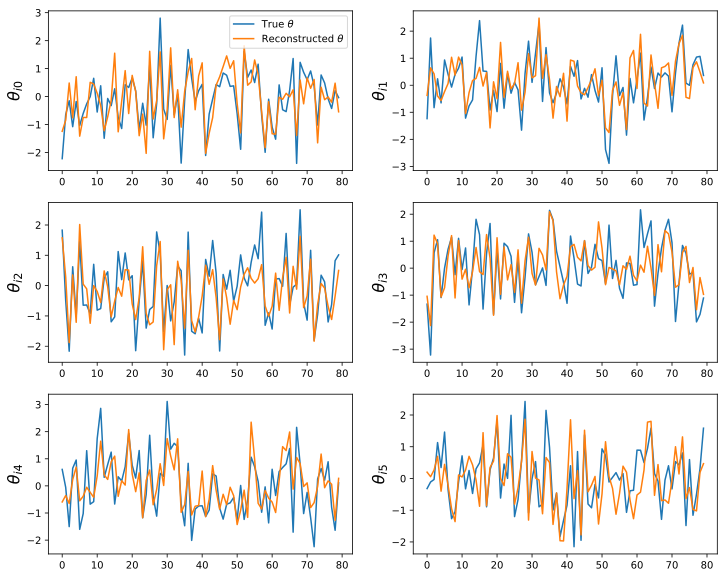

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = "svg"

fig, axs = plt.subplots(3,2, figsize=(12,10))
for l in range(L):
    row_idx = int(l / 2)
    col_idx = int(l % 2)
    ax = axs[row_idx, col_idx]
    
    ax.plot(theta_true[:,l], label=r"True $\theta$")
    ax.plot(a2dr_theta[:,l], label=r"Reconstructed $\theta$")
    ax.set_ylabel(r"$\theta_{{i{}}}$".format(l), fontsize=16)
    if l == 0:
        ax.legend(loc="upper right")
plt.show()